## Imports & Setup

In [28]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, RandomAdjustSharpness, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *
from architecture.AutoEncoder import *

In [29]:
torch.manual_seed(109)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [31]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), Grayscale(1),
                          RandomAdjustSharpness(2, p=1), 
                          ToTensor(), Normalize(mean=[0.4814], std=[0.2136])])

In [32]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
train_loader = produce_loader(train_data, batch_size, shuffle=True)

In [33]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [34]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1218, 2799, 4274, 5856, 4366, 3721, 4422, 811, 1110]


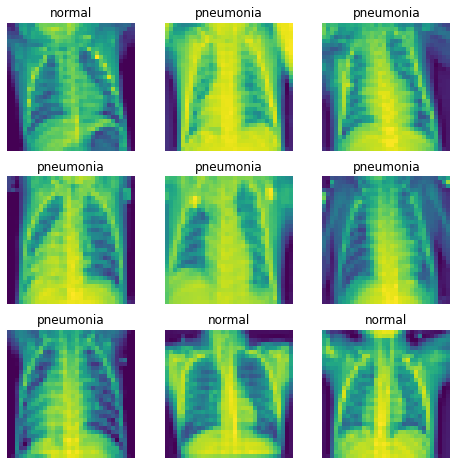

In [35]:
visualize_data(train_data)

[531, 149, 380, 59, 555, 309, 358, 283, 40]


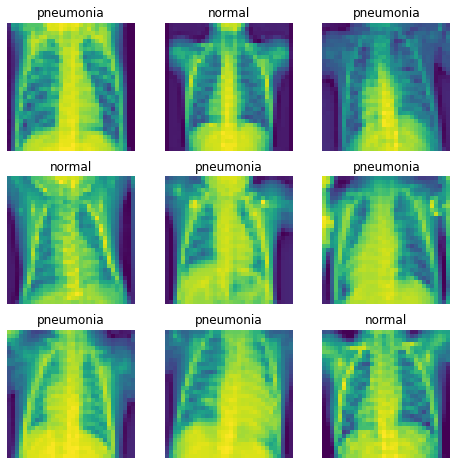

In [36]:
visualize_data(test_data)

## Load AutoEncoder

In [37]:
# number of hidden layers and their sizes
hidden_a = [1, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [38]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256_4epochs")["model_state_dict"])

<All keys matched successfully>

In [39]:
for param in autoencmodel.parameters():
    param.requiresGrad = False
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Initialise Model

Parameters that can be changed:

1) Kernel size

2) hidden - no. of neurons in each layer and no. of layers)

3) window - window size for max-pooling

4) blocks - no.of neurons in transformer block


In [40]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False,weight_decay=1e-5):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [41]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]
dropout=0.5

In [42]:
model = Transformer(hidden, kernel_size, window, blocks,dropout).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=2592, out_fe

In [43]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [44]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [45]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20, autoencoder=autoencmodel)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.4453125
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.4934895833333333
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5198863636363636
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.54296875
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5625
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5733173076923077
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.586945564516129
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.6015625
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.6101371951219512
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.6229619565217391
--- Epoch 1/20: Train loss: 0.6503, Train accuracy: 0.6251
--- Epoch 1/20: Val loss: 0.6620, Val accuracy: 0.6103
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.7109375
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.7369791666666666
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.7393465909090909
Epoch 2/20, Batch number: 15, Cumulated a

Epoch 11/20, Batch number: 30, Cumulated accuracy: 0.8092237903225806
Epoch 11/20, Batch number: 35, Cumulated accuracy: 0.8059895833333334
Epoch 11/20, Batch number: 40, Cumulated accuracy: 0.8084984756097561
Epoch 11/20, Batch number: 45, Cumulated accuracy: 0.8092730978260869
--- Epoch 11/20: Train loss: 0.4347, Train accuracy: 0.8093
--- Epoch 11/20: Val loss: 0.3488, Val accuracy: 0.8957
Stopped early due to increasing validation loss.


## Testing Model & Performance Curves

In [19]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)

Test loss: 0.3284, Test accuracy: 0.8838


Precision: 0.9051918735891648
Recall: 0.9391100702576113
F1 score: 0.9218390804597701


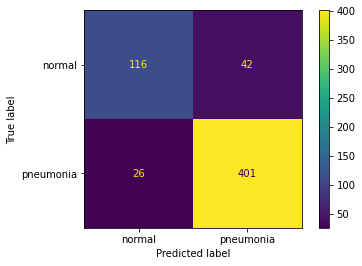

In [20]:
show_metrics(true_labels, model_preds)

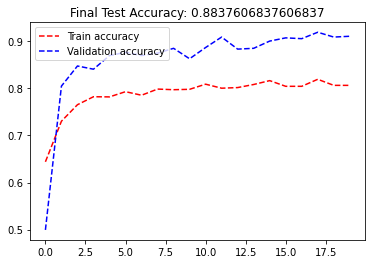

In [21]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

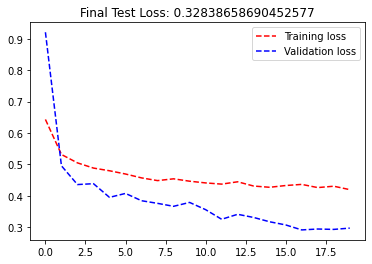

In [22]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [23]:
test_loader2 = produce_loader(test_data, 1)

In [24]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2, autoencmodel)

Precision: 0.9166666666666666
Recall: 0.927400468384075
F1 score: 0.9220023282887078


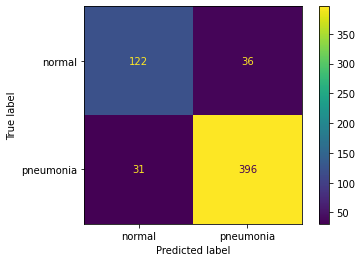

In [25]:
show_metrics(true_labels2, model_preds2)

[506, 347, 98, 397, 415, 35, 140, 44, 380, 436, 250, 37, 241, 361, 257, 81, 461, 319, 72, 498, 139, 200, 476, 0, 410]


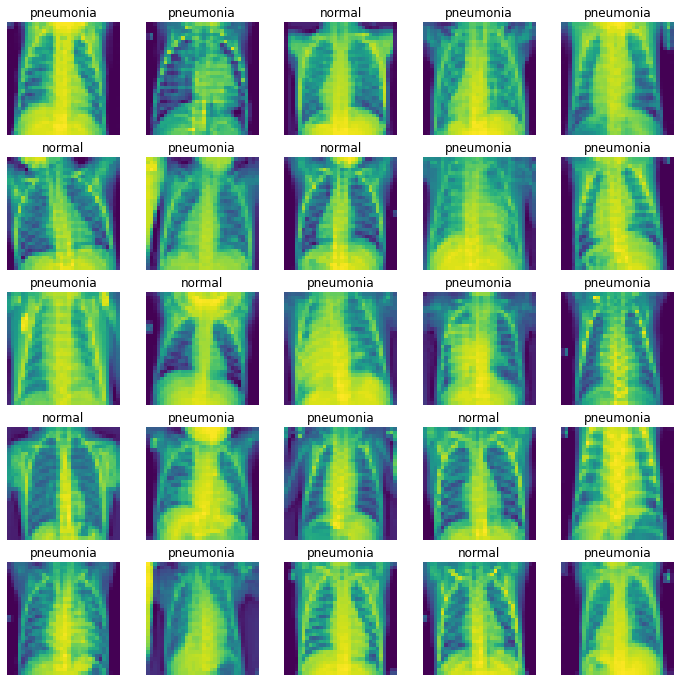

In [26]:
visualize_data(correct_list, (12,12), 5)

[46, 11, 44, 31, 0, 46, 53, 0, 44, 53, 36, 45, 47, 4, 1, 46, 65, 14, 45, 12, 37, 32, 7, 46, 26]


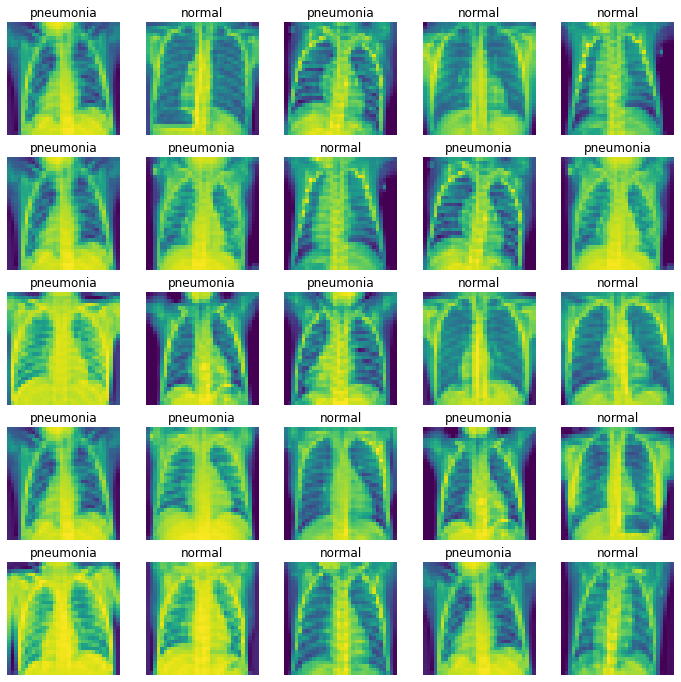

In [27]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './Transformer_10epochs_withAutoEncoder')

## Hyperparam tuning

Parameters that can be changed:

1) kernel_list

2) hidden_list - no. of neurons in each layer and no. of layers)

3) window_list - window size for max-pooling

4) blocks_list - no.of neurons in linear layers and no. of linear layers

5) dropout_list - probability for dropout layers

6) lr_list - learning rates for optimiser

In [24]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

lr=0.01

lr_list=[0.01,0.005,0.001]

kernel_list=[3,5,7]

window_list=[2,3,5]

blocks_list=[[flattened, 512, 64], [flattened, 512, 256, 64], [flattened, 512, 128, 64]]

weight_decay=1e-5

hidden_list=[ [256, 256, 64, 32], [256,128,64,32]]

dropout_list=[0.3,0.5,0.7]

In [25]:
test_param="dropout"
test_losses = []
test_accuracies = []
precision_list=[]
recall_list=[]
f1_list=[]
epochs=10

for dropout in dropout_list:
    print(test_param+'='+str(dropout))
    new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
    channels = hidden[-1]
    changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )
    flattened = channels*changed_img*changed_img
    blocks[0]=flattened
    
    
    model = Transformer( hidden=hidden, kernel_size=kernel_size,
                  window=window, blocks=blocks,dropout=dropout).to(device)
    
    
   
    optimizer = create_adam_optimizer(model, lr=lr, weight_decay=weight_decay)
    
    tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = epochs, autoencoder=autoencmodel)
    true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)
    p,r,f= return_metrics(true_labels, model_preds)
                           
    test_losses+=[test_loss]
    test_accuracies+=[test_accuracy]
    precision_list+=[p]
    recall_list+=[r]
    f1_list+=[f]

dropout=0.3
Epoch 1/10, Batch number: 0, Cumulated accuracy: 0.46875
Epoch 1/10, Batch number: 5, Cumulated accuracy: 0.54296875
Epoch 1/10, Batch number: 10, Cumulated accuracy: 0.6136363636363636
Epoch 1/10, Batch number: 15, Cumulated accuracy: 0.64111328125
Epoch 1/10, Batch number: 20, Cumulated accuracy: 0.6748511904761905
Epoch 1/10, Batch number: 25, Cumulated accuracy: 0.7049278846153846
Epoch 1/10, Batch number: 30, Cumulated accuracy: 0.7212701612903226
Epoch 1/10, Batch number: 35, Cumulated accuracy: 0.7335069444444444
Epoch 1/10, Batch number: 40, Cumulated accuracy: 0.7416158536585366
Epoch 1/10, Batch number: 45, Cumulated accuracy: 0.751358695652174
--- Epoch 1/10: Train loss: 0.5414, Train accuracy: 0.7524
--- Epoch 1/10: Val loss: 0.3218, Val accuracy: 0.8769
Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.8984375
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.8463541666666666
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.8373579545454546
Epoch 2/10, Bat

Epoch 1/10, Batch number: 30, Cumulated accuracy: 0.5824092741935484
Epoch 1/10, Batch number: 35, Cumulated accuracy: 0.5935329861111112
Epoch 1/10, Batch number: 40, Cumulated accuracy: 0.6067073170731707
Epoch 1/10, Batch number: 45, Cumulated accuracy: 0.614639945652174
--- Epoch 1/10: Train loss: 0.6649, Train accuracy: 0.6160
--- Epoch 1/10: Val loss: 0.5088, Val accuracy: 0.7368
Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.71875
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.6614583333333334
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.6803977272727273
Epoch 2/10, Batch number: 15, Cumulated accuracy: 0.6904296875
Epoch 2/10, Batch number: 20, Cumulated accuracy: 0.6964285714285714
Epoch 2/10, Batch number: 25, Cumulated accuracy: 0.7049278846153846
Epoch 2/10, Batch number: 30, Cumulated accuracy: 0.7129536290322581
Epoch 2/10, Batch number: 35, Cumulated accuracy: 0.7144097222222222
Epoch 2/10, Batch number: 40, Cumulated accuracy: 0.7221798780487805
Epoch 2/1

Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.515625
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.5013020833333334
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.4872159090909091
Epoch 2/10, Batch number: 15, Cumulated accuracy: 0.4931640625
Epoch 2/10, Batch number: 20, Cumulated accuracy: 0.4914434523809524
Epoch 2/10, Batch number: 25, Cumulated accuracy: 0.4948918269230769
Epoch 2/10, Batch number: 30, Cumulated accuracy: 0.4891633064516129
Epoch 2/10, Batch number: 35, Cumulated accuracy: 0.4906684027777778
Epoch 2/10, Batch number: 40, Cumulated accuracy: 0.49447408536585363
Epoch 2/10, Batch number: 45, Cumulated accuracy: 0.49507472826086957
--- Epoch 2/10: Train loss: 0.6927, Train accuracy: 0.4966
--- Epoch 2/10: Val loss: 0.6708, Val accuracy: 0.7299
Epoch 3/10, Batch number: 0, Cumulated accuracy: 0.5390625
Epoch 3/10, Batch number: 5, Cumulated accuracy: 0.5104166666666666
Epoch 3/10, Batch number: 10, Cumulated accuracy: 0.4921875
Epoch 3/10, Batch number:

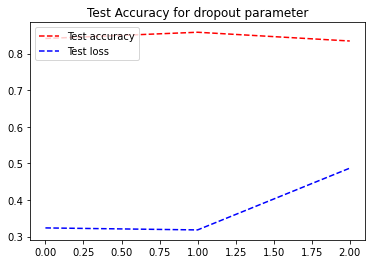

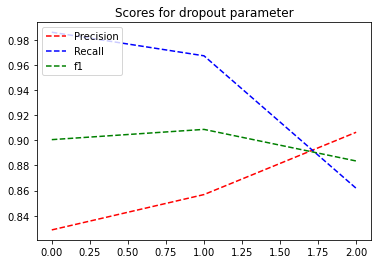

In [26]:
plt.plot(test_accuracies, "r--", label='Test accuracy')
plt.plot(test_losses, "b--", label='Test loss')
plt.title(f'Test Accuracy for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

plt.plot(precision_list, "r--", label='Precision')
plt.plot(recall_list, "b--", label='Recall')
plt.plot(f1_list, "g--", label='f1')
plt.title(f'Scores for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

In [27]:
print(f'test accuracy: {test_accuracies}')
print(f'test loss: {test_losses}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'f1 score: {f1_list}')

test accuracy: [0.841025641025641, 0.8581196581196581, 0.8341880341880342]
test loss: [0.32372383773326874, 0.31826016008853913, 0.48695518374443053]
precision: [0.8287401574803149, 0.8568464730290456, 0.9064039408866995]
recall: [0.9859484777517564, 0.9672131147540983, 0.8618266978922716]
f1 score: [0.9005347593582889, 0.9086908690869085, 0.8835534213685474]
